In [15]:
# Cell 1: Import libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import skfuzzy as fuzz
from skfuzzy import control as ctrl

%matplotlib inline


In [22]:
import pandas as pd

# If your file is comma-separated
df = pd.read_csv("./data/winequality-red.csv", sep=",")

# Clean column names
df.columns = df.columns.str.strip().str.lower().str.replace(" ", "_")

print("Columns:", df.columns)
print(df.head())


Columns: Index(['fixed_acidity', 'volatile_acidity', 'citric_acid', 'residual_sugar',
       'chlorides', 'free_sulfur_dioxide', 'total_sulfur_dioxide', 'density',
       'ph', 'sulphates', 'alcohol', 'quality'],
      dtype='object')
   fixed_acidity  volatile_acidity  citric_acid  residual_sugar  chlorides  \
0            7.4              0.70         0.00             1.9      0.076   
1            7.8              0.88         0.00             2.6      0.098   
2            7.8              0.76         0.04             2.3      0.092   
3           11.2              0.28         0.56             1.9      0.075   
4            7.4              0.70         0.00             1.9      0.076   

   free_sulfur_dioxide  total_sulfur_dioxide  density    ph  sulphates  \
0                 11.0                  34.0   0.9978  3.51       0.56   
1                 25.0                  67.0   0.9968  3.20       0.68   
2                 15.0                  54.0   0.9970  3.26       0.65   


In [23]:
# Take 200 random rows for smaller dataset
df_small = df.sample(n=200, random_state=42).reset_index(drop=True)
print("Small dataset shape:", df_small.shape)

Small dataset shape: (200, 12)


In [33]:
# Input variables
alcohol = ctrl.Antecedent(np.arange(7, 15, 0.1), 'alcohol')
acidity = ctrl.Antecedent(np.arange(2.5, 4.5, 0.01), 'acidity')  # using pH

# Output variable
quality = ctrl.Consequent(np.arange(0, 11, 1), 'quality')

# Membership functions for alcohol
alcohol['low'] = fuzz.trimf(alcohol.universe, [7, 8, 9.5])
alcohol['medium'] = fuzz.trimf(alcohol.universe, [8.5, 10.5, 12.5])
alcohol['high'] = fuzz.trimf(alcohol.universe, [11, 13, 15])

# Membership functions for acidity (pH)
acidity['low'] = fuzz.trimf(acidity.universe, [2.5, 3.0, 3.4])
acidity['medium'] = fuzz.trimf(acidity.universe, [3.2, 3.5, 3.8])
acidity['high'] = fuzz.trimf(acidity.universe, [3.6, 4.0, 4.5])

# Membership functions for quality
quality['bad'] = fuzz.trimf(quality.universe, [0, 2, 4])
quality['average'] = fuzz.trimf(quality.universe, [3, 5, 7])
quality['good'] = fuzz.trimf(quality.universe, [6, 8, 10])



In [34]:
# Rules
rule1 = ctrl.Rule(alcohol['high'] & acidity['low'], quality['good'])
rule2 = ctrl.Rule(alcohol['high'] & acidity['medium'], quality['good'])
rule3 = ctrl.Rule(alcohol['medium'] & acidity['low'], quality['average'])
rule4 = ctrl.Rule(alcohol['medium'] & acidity['medium'], quality['average'])
rule5 = ctrl.Rule(alcohol['low'] & acidity['low'], quality['bad'])
rule6 = ctrl.Rule(acidity['high'], quality['bad'])  # override if acidity too high


In [43]:
predictions = []

for idx, row in df_small.iterrows():
    try:
        # Set fuzzy inputs
        quality_sim.input['alcohol'] = row['alcohol']
        quality_sim.input['acidity'] = row['ph']

        # Compute fuzzy output
        quality_sim.compute()

        # Save prediction
        predictions.append(quality_sim.output['quality'])
    except Exception as e:
        print(f"Row {idx} error: {e}")
        predictions.append(None)  # keep alignment

# Add predictions as a new column
df_small['predicted_quality'] = predictions

print(df_small[['alcohol', 'ph', 'predicted_quality']].head())


   alcohol    ph  predicted_quality
0      9.6  3.24                5.0
1      9.5  3.39                5.0
2      9.9  3.28                5.0
3      9.8  3.33                5.0
4     10.6  3.39                5.0


In [49]:
df_small.head()

,fixed_acidity,volatile_acidity,citric_acid,residual_sugar,chlorides,free_sulfur_dioxide,total_sulfur_dioxide,density,ph,sulphates,alcohol,quality,predicted_quality,predicted_label
0,7.7,0.56,0.08,2.50,0.114,14.0,46.0,0.9971,3.24,0.66,9.6,6,5.0,Medium
1,7.8,0.50,0.17,1.60,0.082,21.0,102.0,0.9960,3.39,0.48,9.5,5,5.0,Medium
2,10.7,0.67,0.22,2.70,0.107,17.0,34.0,1.0004,3.28,0.98,9.9,6,5.0,Medium
3,8.5,0.46,0.31,2.25,0.078,32.0,58.0,0.9980,3.33,0.54,9.8,5,5.0,Medium
4,6.7,0.46,0.24,1.70,0.077,18.0,34.0,0.9948,3.39,0.60,10.6,6,5.0,Medium


In [45]:
# Define labeling based on fuzzy prediction
def label_quality(value):
    if value < 4:
        return "Low"
    elif value < 7:
        return "Medium"
    else:
        return "High"

df_small['predicted_label'] = df_small['predicted_quality'].apply(label_quality)

print(df_small[['quality', 'predicted_quality', 'predicted_label']].head(10))




   quality  predicted_quality predicted_label
0        6           5.000000          Medium
1        5           5.000000          Medium
2        6           5.000000          Medium
3        5           5.000000          Medium
4        6           5.000000          Medium
5        5           5.000000          Medium
6        5           5.000000          Medium
7        5           5.000000          Medium
8        5           5.000000          Medium
9        6           4.120588          Medium


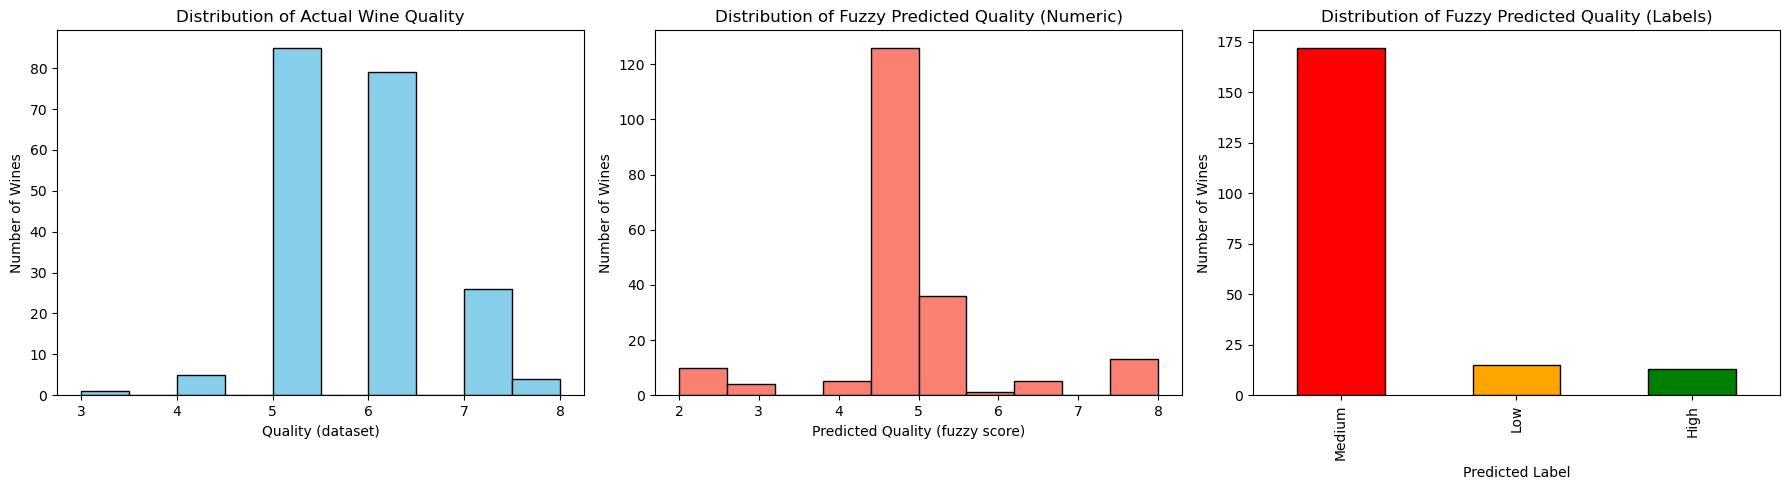

In [48]:
import matplotlib.pyplot as plt

plt.figure(figsize=(18,5))

# 1. Actual wine quality distribution
plt.subplot(1,3,1)
plt.hist(df_small['quality'], bins=10, color='skyblue', edgecolor='black')
plt.title("Distribution of Actual Wine Quality")
plt.xlabel("Quality (dataset)")
plt.ylabel("Number of Wines")

# 2. Fuzzy numeric prediction distribution
plt.subplot(1,3,2)
plt.hist(df_small['predicted_quality'], bins=10, color='salmon', edgecolor='black')
plt.title("Distribution of Fuzzy Predicted Quality (Numeric)")
plt.xlabel("Predicted Quality (fuzzy score)")
plt.ylabel("Number of Wines")

# 3. Fuzzy label distribution (Low, Medium, High)
plt.subplot(1,3,3)
df_small['predicted_label'].value_counts().plot(kind='bar', color=['red','orange','green'], edgecolor='black')
plt.title("Distribution of Fuzzy Predicted Quality (Labels)")
plt.xlabel("Predicted Label")
plt.ylabel("Number of Wines")

plt.tight_layout()
plt.show()

